In [1]:
import tensorflow as tf


In [2]:
tf.__version__

'2.3.0'

<h1>Importing libraries

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
from tensorflow.keras import layers
from os import listdir
import cv2
import time
import imutils 
try:
    from PIL import Image
except ImportError:
    import Image 
import glob
import os

import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

from IPython import display

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h1> Implementing DCGANs on MNIST

<h3>Load and prepare dataset

In [4]:
(train_images, train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

In [7]:
train_images=(train_images-127.5)/127.5 # normalizing the dataset

In [8]:
BUFFER_SIZE=60000
BATCH_SIZE=256

Shuffling the dataset

In [9]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<h1>Generator

In [10]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

generating az image with generator with help of noise vector

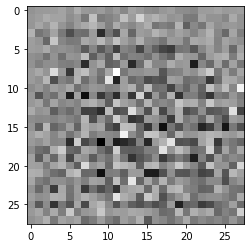

In [11]:
generator=make_generator_model()
noice=tf.random.normal([1,100])
generated_image=generator(noice,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

<h1>Discriminator

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00098007]], shape=(1, 1), dtype=float32)


<h1>Loss Function

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator Loss

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator and discriminator optimizers

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Saving Checkpoints

In [19]:
checkpoint_dir = '/content/gdrive/My Drive/MNIST_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator,discriminator=discriminator)

Training loops

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
genloss=[]
desloss=[]
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      genloss.append(gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      desloss.append(disc_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,seed)


    # Save the model every 15 epochs
    if (epoch % 15 == 0):
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [25]:
!mkdir /content/gdrive/My\ Drive/MNIST_generated

In [30]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('/content/gdrive/My Drive/MNIST_generated/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

tf.Tensor(
[[-0.41349435  0.74206704  2.1947496  ... -0.20257123  1.7546132
   0.7533786 ]
 [ 1.2893863   0.4924315  -1.8127432  ...  1.5818721   0.7549005
   0.28821188]
 [ 0.38993862  0.8944545   0.20794168 ... -0.4592545  -0.6485545
   2.262567  ]
 ...
 [ 0.550887    0.8672788  -1.0182515  ... -0.7054175  -0.5571859
   1.883022  ]
 [-0.0431968   0.9541098   0.6298319  ...  0.55514824 -0.57845443
   1.7621357 ]
 [ 0.03457807  1.8783907  -0.0091826  ...  0.31901273 -0.5915724
   1.1388134 ]], shape=(16, 100), dtype=float32)


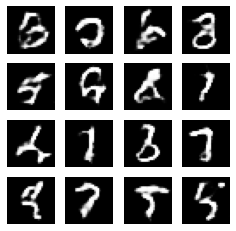

In [31]:
train(train_dataset, 50)

In [32]:

genloss

[<tf.Tensor: shape=(), dtype=float32, numpy=0.68750215>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6628792>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6411895>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.62235594>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6083558>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5960906>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.58245015>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.57050675>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5606255>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5467626>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5337445>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.51903033>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5101805>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49985263>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4962193>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49652776>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49366325>,
 <tf.Tensor: shape=(), dtype=float32, nu

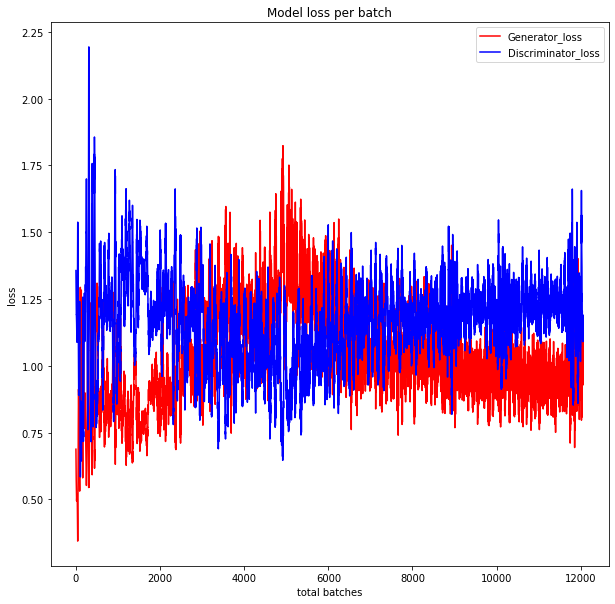

In [33]:
plt.figure(figsize=(10,10))
plt.plot(genloss,color='red',label='Generator_loss')
plt.plot(desloss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

Restore last checkpoint

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

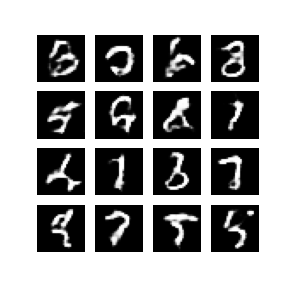

In [38]:
def display_image(epoch_no):
  return PIL.Image.open('/content/gdrive/My Drive/MNIST_generated/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [39]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/gdrive/My Drive/MNIST_generated/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [40]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<h1>Implementing DCGANs on celeba datasets

<h3>Loading data

In [8]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2020-08-08 16:45:00--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.192
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  72.9MB/s    in 19s     

2020-08-08 16:45:19 (73.9 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [9]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [10]:
!ls data_faces/img_align_celeba/

Streaming output truncated to the last 5000 lines.
028769.jpg  062536.jpg	096303.jpg  130070.jpg	163837.jpg  197604.jpg
028770.jpg  062537.jpg	096304.jpg  130071.jpg	163838.jpg  197605.jpg
028771.jpg  062538.jpg	096305.jpg  130072.jpg	163839.jpg  197606.jpg
028772.jpg  062539.jpg	096306.jpg  130073.jpg	163840.jpg  197607.jpg
028773.jpg  062540.jpg	096307.jpg  130074.jpg	163841.jpg  197608.jpg
028774.jpg  062541.jpg	096308.jpg  130075.jpg	163842.jpg  197609.jpg
028775.jpg  062542.jpg	096309.jpg  130076.jpg	163843.jpg  197610.jpg
028776.jpg  062543.jpg	096310.jpg  130077.jpg	163844.jpg  197611.jpg
028777.jpg  062544.jpg	096311.jpg  130078.jpg	163845.jpg  197612.jpg
028778.jpg  062545.jpg	096312.jpg  130079.jpg	163846.jpg  197613.jpg
028779.jpg  062546.jpg	096313.jpg  130080.jpg	163847.jpg  197614.jpg
028780.jpg  062547.jpg	096314.jpg  130081.jpg	163848.jpg  197615.jpg
028781.jpg  062548.jpg	096315.jpg  130082.jpg	163849.jpg  197616.jpg
028782.jpg  062549.jpg	096316.jpg  130083.jpg	163850

In [4]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [5]:
def load_data(dir_list,image_size):
  X=[]
  image_width,image_height=image_size
  i=0
  for directory in listdir(dir_list):
    #for filename in listdir(dir_list+"/"+directory):
    #image=cv2.imread(dir_list+"/"+directory)
    image=crop_image_contours( dir_list+"/"+directory ,plot=False)
    #image=detect_faces(dirlist)
    image=cv2.resize(image,(image_width,image_height),interpolation=cv2.INTER_CUBIC)
    image=image/255
    X.append(image)
    i=i+1
    if i==50000:
      break;
      #if directory=="yes":
        #Y.append([1])
      #else:
        #Y.append([0])
  #X,Y=shuffle(X,Y)
  X=np.array(X)
  #Y=np.array(Y)
  #print(f"Number of examples : {len(X)}")
  print(f"X shape is : {X.shape}")
  #print(f"Y shape is : {Y.shape}")

  return X

Just trying contours


In [6]:
def crop_image_contours( image ,plot=False):
  # load the image, convert it to grayscale, and blur it slightly
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  # find contours in thresholded image, then grab the largest
  # one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # determine the most extreme points along the contour
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.tick_params(axis="both",which="both",top=False,bottom=False,left=False,right=False,labeltop=False,labelbottom=False,labelleft=False,labelright=False)
    plt.title("Original_image")
    plt.show()
    plt.figure()
    plt.subplot(1,2,2)
    plt.imshow(new_image)
    plt.tick_params(axis="both",which="both",top=False,bottom=False,left=False,right=False,labeltop=False,labelbottom=False,labelleft=False,labelright=False)
    plt.title("Cropped_image")
    plt.show()

  return new_image


In [7]:
X=load_data("/content/data_faces/img_align_celeba",(64,64))

X shape is : (50000, 64, 64, 3)


In [8]:
BUFFER_SIZE=60000
BATCH_SIZE=256

Shuffling data

In [9]:
train_dataset=tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

plotting cropped images

In [10]:
def plot_images(X,n=50):
  # n is number of examples to plot
  n_images = X[:n]
  columns_n=10
  rows_n=int(n/columns_n)
  plt.figure(figsize=(20,10))
  i=1 # current plot
  for image in n_images:
      plt.subplot(rows_n, columns_n, i)
      plt.imshow(image)
        # remove ticks
      plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
      i += 1
    #label_to_str = lambda label: "Yes" if label == 1 else "No"
    #plt.suptitle(f"Brain Tumor: {label_to_str(labels)}")
  plt.show()

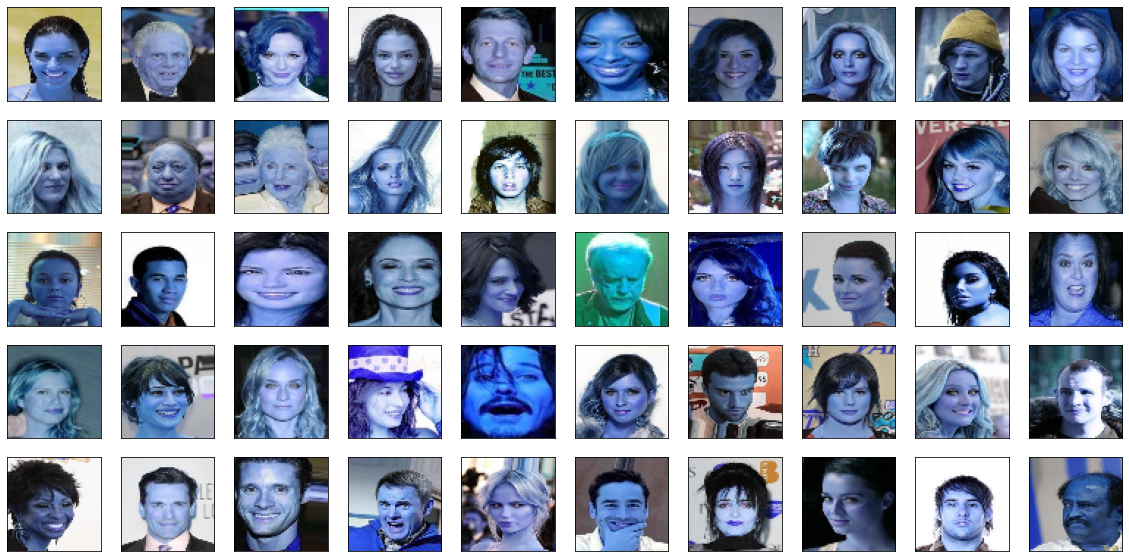

In [11]:
plot_images(X)

# <h3>Generator

In [25]:
def make_generator_model2():
  model2=tf.keras.Sequential()
  model2.add(layers.Dense(4*4*256,use_bias=False,input_shape=(100,)))
  #model2.add(layers.BatchNormalization())
  #model2.add(layers.LeakyReLU())
  model2.add(layers.Reshape((4,4,256)))
  assert model2.output_shape==(None,4,4,256)

  model2.add(layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same",use_bias=False))
  assert model2.output_shape==(None,8,8,256)
  model2.add(layers.LeakyReLU(alpha=0.2))
  model2.add(layers.BatchNormalization())
  #model2.add(layers.LeakyReLU())

  model2.add(layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same",use_bias=False))
  assert model2.output_shape==(None,16,16,128)
  model2.add(layers.BatchNormalization())
  model2.add(layers.LeakyReLU(alpha=0.2))

  model2.add(layers.Conv2DTranspose(64,kernel_size=4,strides=2,padding="same",use_bias=False))
  assert model2.output_shape==(None,32,32,64)
  model2.add(layers.BatchNormalization())
  model2.add(layers.LeakyReLU(alpha=0.2))

  model2.add(layers.Conv2DTranspose(3,kernel_size=4,strides=2,padding="same",use_bias=False,activation='sigmoid'))
  assert model2.output_shape==(None,64,64,3)

  return model2

plotting random imges through generator

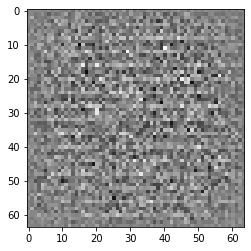

In [26]:
generator=make_generator_model2()
noice=tf.random.normal([1,100])
generated_image=generator(noice,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

<h3>Discriminator

In [27]:

def make_discriminator_model2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=4,strides=2, padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.Conv2D(64, kernel_size=4,strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, kernel_size=4,strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, kernel_size=4,strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid"))

    return model

In [28]:
discriminator = make_discriminator_model2()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5011886]], shape=(1, 1), dtype=float32)


<h3>optimizers

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
checkpoint_dir = '/content/gdrive/My Drive/celeba_training2_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator,discriminator=discriminator)

In [31]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Losses

In [32]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [34]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Training loops

In [35]:
#@tf.function
genlosses=[]
deslossess=[]
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      genlosses.append(gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      deslossess.append(disc_loss)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return (fake_output,real_output)

In [36]:
!mkdir /content/gdrive/My\ Drive/celeba_generated

mkdir: cannot create directory ‘/content/gdrive/My Drive/celeba_generated’: File exists


In [38]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      (fake_output,real_output)=train_step(image_batch)

    gen_loss = generator_loss(fake_output)
    #print(gen_loss)
    
      
    disc_loss = discriminator_loss(real_output, fake_output)
    #print(disc_loss)
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,seed)


    # Save the model every 15 epochs
    if (epoch % 15 == 0):
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :]))
      plt.axis('off')

  plt.savefig('/content/gdrive/My Drive/celeba_generated/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

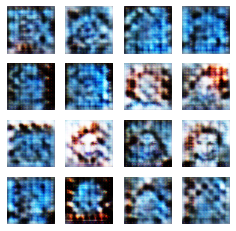

In [40]:
train(train_dataset,100)

In [41]:
genlosses



[<tf.Tensor: shape=(), dtype=float32, numpy=0.46698532>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.51298594>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.54884>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5797372>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6123214>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6432393>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65263987>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66118556>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6652549>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66728324>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.67011905>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6703442>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6705213>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6701508>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6721989>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6660536>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6703959>,
 <tf.Tensor: shape=(), dtype=float32, numpy=

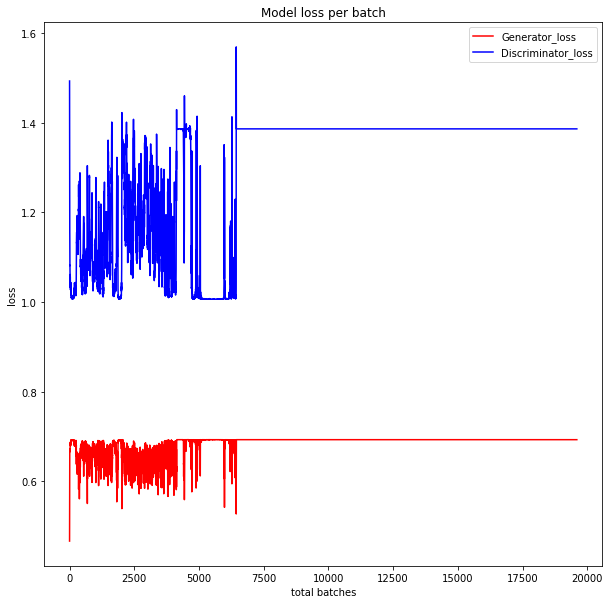

In [51]:
plt.figure(figsize=(10,10))
plt.plot(genlosses,color='red',label='Generator_loss')
plt.plot(deslossess,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

restoring last checkpoint

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

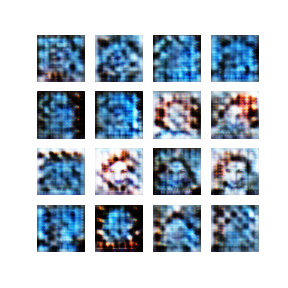

In [46]:
def display_image(epoch_no):
  return PIL.Image.open('/content/gdrive/My Drive/celeba_generated/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(100)

In [49]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/gdrive/My Drive/celeba_generated/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [50]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>